# Testing rotations from displacement fields

It's not too hard to rotate vectors when an affine transform rotates the frame of an entire 3d image. It's currently a bit more difficult to rotate a vector when the *local* environment has rotated due to displacements.

Here we generate a straight line and a sinusoid that we will replicate in z to create a 3d image.

/Users/mcieslak/miniconda3/envs/py3k/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


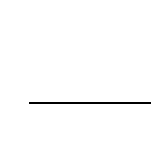

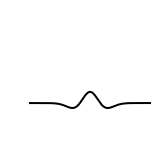

In [1]:
import matplotlib
import nibabel as nb
matplotlib.use('agg')
import os
from mpl_toolkits.mplot3d import axes3d
%pylab inline
import numpy as np
from dipy.core.geometry import vec2vec_rotmat, decompose_matrix, cart2sphere
from skimage.filters import gaussian
from scipy.stats import norm

x = np.linspace(-2*np.pi,2*np.pi,500)
y0 = np.zeros_like(x)
y1 = 10 * (norm.pdf(x, scale=1) - norm.pdf(x, scale=1.1))

def rasterized2d(x,y, n_slices=64, sigma=5, lw=5):
    fig, ax = plt.subplots(figsize=(2,2))
    ax.plot(x,y,color="black", lw=lw)
    ax.patch.set_facecolor('black')
    ax.set_ylim(-1,3)
    ax.set_xlim(-2*np.pi,2*np.pi)
    plt.axis('off')
    fig.canvas.draw()
    fig.tight_layout(pad=0)
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    slice_data =  (data.sum(2) < 100).astype(np.float)
    slice_data = gaussian(slice_data, sigma=sigma)
    return np.dstack([slice_data[...,None]] * n_slices)


affine = np.array([
    [-1.,  0.,  0.,  72.],
    [ 0., -1.,  0.,  72.],
    [ 0.,  0.,  1., -32.],
    [ 0.,  0.,  0.,   1.]
])

# Make nifti files
sigma=0.5
lw=2
line = nb.Nifti1Image(rasterized2d(x,y0, n_slices=64, sigma=sigma,lw=lw), affine)
squiggle = nb.Nifti1Image(rasterized2d(x,y1,n_slices=64, sigma=sigma,lw=lw), affine)

line.to_filename("line.nii.gz")
squiggle.to_filename("squiggle.nii.gz")

register the line to the squiggle

In [2]:
import os
os.system("ANTSPATH=/Users/mcieslak/projects/ANTs/build/bin/ " 
          "antsRegistrationSyNQuick.sh " \
    "-d 3 -f squiggle.nii.gz -m line.nii.gz " \
    "-o SyN -t s -j 1 -e 999")

0

Merge the affine and the displacement field

In [3]:
# Compose the affine and warp
os.system("antsApplyTransforms "
  "-o [line_to_squiggle.nii.gz, 1] "
  "-d 3 " 
  "-r line.nii.gz " 
  "-t SyN1Warp.nii.gz "
  "-t SyN0GenericAffine.mat" )

os.system("antsApplyTransforms "
  "-o [squiggle_to_line.nii.gz, 1] "
  "-d 3 " 
  "-r line.nii.gz " 
  "-t [SyN0GenericAffine.mat, 1] "
  "-t SyN1InverseWarp.nii.gz")


0

Plot the displacement fields and the background images

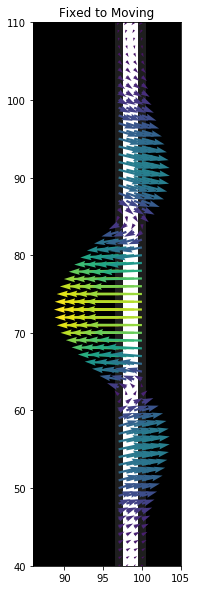

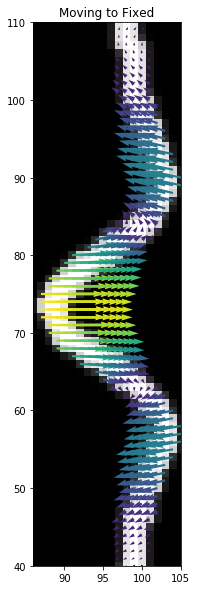

In [4]:

def plot_image_and_vector(bg_image, vector_image,slicenum=32,
                          img_threshold=0.1, title="Displacement", every=1):
    bg_img = nb.load(bg_image)
    bg_data = bg_img.get_data()[...,slicenum]
    
    fig,ax = plt.subplots(figsize=(10,10))
    # Reverse axes 
    ax.imshow(bg_data.T,interpolation="nearest",cmap="gray", origin="lower",aspect="equal")
    
    vector_img = nb.load(vector_image)
    vector_data = vector_img.get_data().squeeze()[:,:,slicenum,:]
    arrow_mask = bg_data > img_threshold
    
    arrow_x, arrow_y = np.nonzero(arrow_mask)
    arrow_u, arrow_v,_ = vector_data[arrow_mask].T
    ax.quiver(arrow_x, arrow_y, arrow_u, arrow_v, 
              np.sqrt(arrow_u**2 + arrow_v**2),
              angles="xy", scale_units="xy", scale=1,
              width=0.015
             )
    ax.set_xlim(86,105)
    ax.set_ylim(40,110)
    ax.set_title(title)
plot_image_and_vector("line.nii.gz", "squiggle_to_line.nii.gz", title="Fixed to Moving")
plot_image_and_vector("squiggle.nii.gz","line_to_squiggle.nii.gz", title="Moving to Fixed")

Make a fake vector image that is aligned with the moving image. This represents a orientation before any displacements are applied:

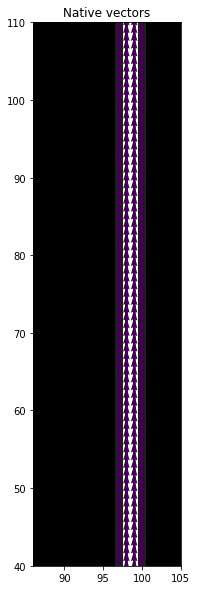

In [5]:
def get_vector_nii(data):
    hdr = line.header.copy()
    hdr.set_data_dtype(np.dtype('<f4'))
    hdr.set_intent('vector', (), '')
    return nb.Nifti1Image(data[:, :, :, np.newaxis, :].astype(
                          np.dtype('<f4')), affine, hdr)
    
data = line.get_data()
zeros = np.zeros_like(data)
field = [zeros, 5.0 * (data > 0), zeros]
field = np.stack(field, -1)

native_vectors = get_vector_nii(field).to_filename("native_vectors.nii.gz")
plot_image_and_vector("line.nii.gz","native_vectors.nii.gz", title="Native vectors")


Use ants ApplyTransforms to these vectors to see if they're correctly reoriented. They're not supposed to be...

In [6]:
os.system("antsApplyTransforms -e 1 -d 3 -i native_vectors.nii.gz "
          "-o warped_vectors.nii.gz -t line_to_squiggle.nii.gz "
          "-r squiggle.nii.gz -v 1")

0

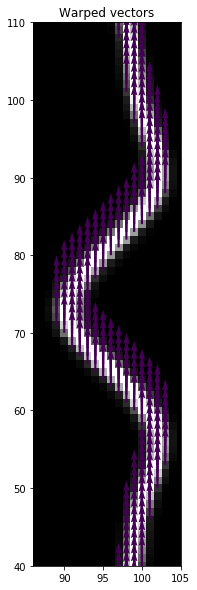

In [7]:
plot_image_and_vector("SyNWarped.nii.gz","warped_vectors.nii.gz", title="Warped vectors")

We need to calculate the curl introduced by the displacement field. Load one of the warps and calculate the curl based on [the explanation here](https://mathinsight.org/curl_components):

In [8]:
import SimpleITK as sitk
def gradient_itk(warp_img):
    """Reads a warp nifti file and returns the gradients 
    in x, y and z"""
    img_nb = nb.load(warp_img)
    img = sitk.ReadImage(warp_img)
    get0 = sitk.VectorIndexSelectionCastImageFilter()
    get0.SetIndex(0)
    get1 = sitk.VectorIndexSelectionCastImageFilter()
    get1.SetIndex(1)
    get2 = sitk.VectorIndexSelectionCastImageFilter()
    get2.SetIndex(2)

    dispx = get0.Execute(img)
    dispy = get1.Execute(img)
    dispz = get2.Execute(img)

    grad = sitk.GradientImageFilter()
    gradx = grad.Execute(dispx)
    grady = grad.Execute(dispy)
    gradz = grad.Execute(dispz)

    stacked_gradients = np.concatenate(
        [np.swapaxes(sitk.GetArrayFromImage(gradx),0,2),
         np.swapaxes(sitk.GetArrayFromImage(grady),0,2), 
         np.swapaxes(sitk.GetArrayFromImage(gradz),0,2),
         ], axis=3)

    
    return nb.Nifti1Image(stacked_gradients, img_nb.affine)

inv_warp_grad = gradient_itk("squiggle_to_line.nii.gz")
warp_grad = gradient_itk("line_to_squiggle.nii.gz")

inv_warp_grad.to_filename("squiggle_to_line_gradient.nii.gz")
warp_grad.to_filename("line_to_squiggle_gradient.nii.gz")


Since we know that the rotation will be the same in every voxel for a rigid rotation, let's take a rigid transform matrix and create a displacement field for it. We can check what global rotations will do to original bvecs by using code from `qsiprep` that we already know works. Then we can make sure that we arrive at the same rotation in each voxel using Jacobians based on the rigid-transform-displacements field.

## Testing on pure affine data

From some previous testing I got a transform file that performs a rigid rotation:

In [9]:
%%bash

antsTransformInfo transform0GenericAffine.mat

Transform file: transform0GenericAffine.mat
AffineTransform (0x7f8b54652470)
  RTTI typeinfo:   itk::AffineTransform<double, 3u>
  Reference Count: 3
  Modified Time: 500
  Debug: Off
  Object Name: 
  Observers: 
    none
  Matrix: 
    0.940841 -0.174637 -0.290381 
    0.255803 0.928066 0.270662 
    0.222225 -0.32893 0.917835 
  Offset: [-12.4571, -3.19033, -7.40055]
  Center: [-0.166962, -35.3945, -18.7184]
  Translation: [-0.830601, -5.75334, 5.74265]
  Inverse: 
    0.940841 0.255803 0.222225 
    -0.174637 0.928066 -0.32893 
    -0.290381 0.270662 0.917835 
  Singular: 0



In [10]:
%%bash
antsApplyTransforms \
   -o [rigid_warp.nii.gz, 1] \
   -d 3 \
   -r line.nii.gz \
   -t transform0GenericAffine.mat

In [11]:
rigid_warp_gradient_image = gradient_itk("rigid_warp.nii.gz")
rigid_warp_dims = rigid_warp_gradient_image.shape
rigid_warp_gradient = rigid_warp_gradient_image.get_data()
center_i = rigid_warp_dims[0]//2
center_j = rigid_warp_dims[1]//2
center_k = rigid_warp_dims[2]//2

(dxdx, dxdy, dxdz,
 dydx, dydy, dydz,
 dzdx, dzdy, dzdz) = rigid_warp_gradient[center_i, center_j, center_k]
jac = np.array([
    [dxdx, dxdy, dxdz],
    [dydx, dydy, dydz],
    [dzdx, dzdy, dzdz]
]) 

jacobian_rotation = jac + np.eye(3)
print("Rotation matrix:\n", jacobian_rotation)

Rotation matrix:
 [[ 0.94084062 -0.17463684 -0.2903806 ]
 [ 0.25580278  0.92806616  0.27066243]
 [ 0.22222477 -0.32893038  0.91783493]]


This is identical to the matrix listed in the transform file!!! It works!!!

### testing against the brute-force method

Let's see what happens if we test the code we currently use for rotating b-vecs. First, make a text file with some points that will be warped. These will be warped with `antsApplyTransformsToPoints` and we will see how they are rotated relative to each other.

```
x,y,z,t
0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0
0.0,5.0,0.0,0.0
0.0,0.0,5.0,0.0
-15.0,0.0,0.0,0.0
0.0,-15.0,0.0,0.0
0.0,0.0,-15.0,0.0
```

This is the contents of `orig_points.csv`

In [12]:
%%bash
antsApplyTransformsToPoints \
    -d 3 \
    -i orig_points.csv \
    -t [transform0GenericAffine.mat, 1] \
    -o transform0_rotated_points.csv

In [13]:
from dipy.core.geometry import normalized_vector
aattp_vecs = np.loadtxt("transform0_rotated_points.csv", 
                        skiprows=1, delimiter=",")[:,:3]
new_origin = aattp_vecs[0]
rotated_vecs = normalized_vector(aattp_vecs[1:] - new_origin)

o_vecs = np.loadtxt("orig_points.csv", skiprows=1, delimiter=",")[:,:3]
orig_vecs = normalized_vector(o_vecs[1:])
print("rotated vectors:\n",rotated_vecs)
print("original vectors:\n", orig_vecs)

rotated vectors:
 [[ 0.94084053 -0.1746381  -0.29038016]
 [ 0.25580011  0.9280664   0.27066412]
 [ 0.22223906 -0.3289286   0.91783211]
 [-0.94084034  0.17463718  0.29038131]
 [-0.25580007 -0.92806693 -0.27066232]
 [-0.22222027  0.32893106 -0.91783577]]
original vectors:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]


Note: We have arrived at roughly the same rotation matrix after using `antsApplyTransformsToPoints` to some points that are parallel to the original vectors. Everything makes sense!!

## Rotating vectors and applying transforms

Let's test that we're able to rotate vectors from vector images based on the warps. Recall that we have already warped a set of vectors to the squiggle template:

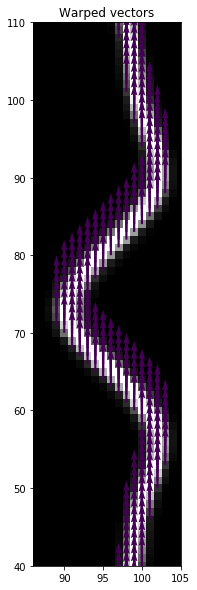

In [14]:
plot_image_and_vector("SyNWarped.nii.gz","warped_vectors.nii.gz", 
                      title="Warped vectors")

Let's take the already-warped vectors and apply some rotations to them to see if they will be correctly oriented.

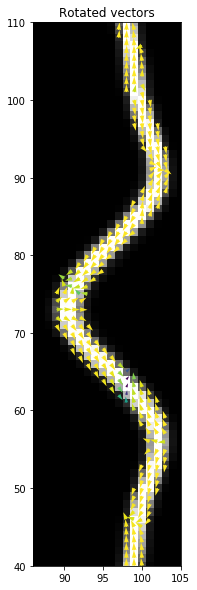

In [15]:
from dipy.core.geometry import normalized_vector
warped_vecs_file = "warped_vectors.nii.gz" # Already in the right place spatially (squiggle)
warp_gradients_file = "line_to_squiggle_gradient.nii.gz" # warps FROM the squiggle to line

def rotate_vectors(gradient_file, vector_file):
    if type(gradient_file) is str:
        gradients_img = nb.load(gradient_file)
    else:
        gradients_img = gradient_file
    # add identity to gradients
    eye_mats = np.concatenate(
        [np.zeros(gradients_img.shape[:3])[...,None] * n for 
         n in np.eye(3).flatten()],-1)
    Rmat = gradients_img.get_data() + eye_mats
    
    if type(vector_file) is str:
        vector_img = nb.load(vector_file)
    else:
        vector_img = vector_file
    
    vectors = vector_img.get_data().squeeze()
    vectors_mask = np.sum(vectors**2,3) > 0
    new_vectors = np.zeros_like(vectors)
    
    original_vectors = vectors[vectors_mask]
    jacobians = Rmat[vectors_mask]
    rotated_vectors = np.zeros_like(original_vectors)
    
    for nvec, (original_vec, jac) in enumerate(zip(
        original_vectors, jacobians)):
        jac_mat = jac.reshape(3,3).T
        new_vec = jac_mat.dot(original_vec).dot(jac_mat.T)
        rotated_vectors[nvec] = new_vec
    
    rotated_vectors = normalized_vector(rotated_vectors)
    output_vectors = np.zeros_like(vectors)
    output_vectors[vectors_mask] = rotated_vectors
    return get_vector_nii(output_vectors)

rotated_vecs_img = rotate_vectors(warp_gradients_file, warped_vecs_file)
rotated_vecs_img.to_filename("rotated_vectors.nii.gz")
plot_image_and_vector("SyNWarped.nii.gz","rotated_vectors.nii.gz", 
                  title="Rotated vectors")


This looks bizarre. Although it's much more correct than the non-warped version. Here is a function that rotates the original vectors and then applies the spatial displacement:

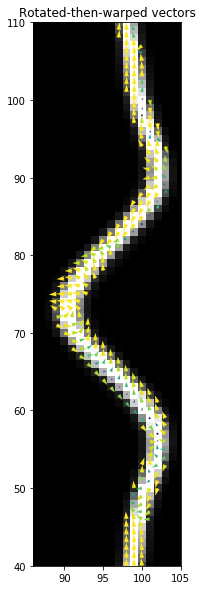

In [16]:
def warp_vectors(native_vectors, composite_warp):
    gradient_image = gradient_itk(composite_warp)
    rotated_vecs_img = rotate_vectors(gradient_image, native_vectors)
    rotated_vecs_img.to_filename("tmp_rotated.nii.gz")
    
    os.system("antsApplyTransforms -e 1 -d 3 -i tmp_rotated.nii.gz "
          "-o tmp_warped_vectors.nii.gz -t %s "
          "-r squiggle.nii.gz -v 1" % composite_warp)
    
warp_vectors("native_vectors.nii.gz", "line_to_squiggle.nii.gz")
plot_image_and_vector("SyNWarped.nii.gz","tmp_warped_vectors.nii.gz", 
                  title="Rotated-then-warped vectors")
